In [1]:
"""
Скачайте материалы к занятию. Проанализируйте ряды, сделайте их стационарными
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline


In [2]:
# Стационарность проверяется тестом Дики-Фуллера - тест на единичные корни (один из тестов).
# Временной ряд имеет единичный корень, или порядок интеграции один, если его первые разности образуют стационарный ряд.
# При помощи этого теста проверяют значение коэффициента a в авторегрессионном уравнении первого порядка AR(1)
# Если a=1, то процесс имеет единичный корень, в этом случае ряд y[t] не стационарен, 
# и является интегрированным временным рядом первого порядка
# Если же а<1, то ряд стационарен
# Для финансово-экономических процессов значение |a|>1 не свойственно, т.к. в этом случае процесс является «взрывным». 
# Возникновение таких процессов маловероятно, поскольку финансово-экономическая среда инерционна, 
# что не позволяет принимать бесконечно большие значения за малые промежутки времени.

# Существует три версии теста (тестовых регрессий):
# 1) Без константы и тренда
# 2) С константой, но без тренда
# 3) С константой и линейным трендом
# Для каждой из трёх тестовых регрессий существуют свои критические значения DF-статистики, 
# которые берутся из специальной таблицы Дики — Фуллера (МакКиннона). 
# Если значение статистики лежит левее критического значения (критические значения — отрицательные) 
# при данном уровне значимости, то нулевая гипотеза о единичном корне отклоняется и процесс признается стационарным

# Если в тестовые регрессии добавить лаги первых разностей временного ряда, 
# то распределение DF-статистики (а значит, критические значения) не изменится. 
# Такой тест называют расширенным тестом
# Необходимость включения лагов первых разностей связана с тем, 
# что процесс может быть авторегрессией не первого, а более высокого порядка

# Источник: 
# https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0

In [6]:
sales_of_company_jan = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
sales_of_company_jan.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [7]:
sales_of_company_1960 = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')
sales_of_company_1960.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [8]:
airline_passengers = pd.read_csv('international-airline-passengers.csv')
airline_passengers.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [12]:
all_series = {
    "Monthly sales of company in january": sales_of_company_jan['Count'],
    "Monthly sales of company in 1960": sales_of_company_1960['Count'],
    "International airline passengers: monthly totals in thousands": airline_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']
}

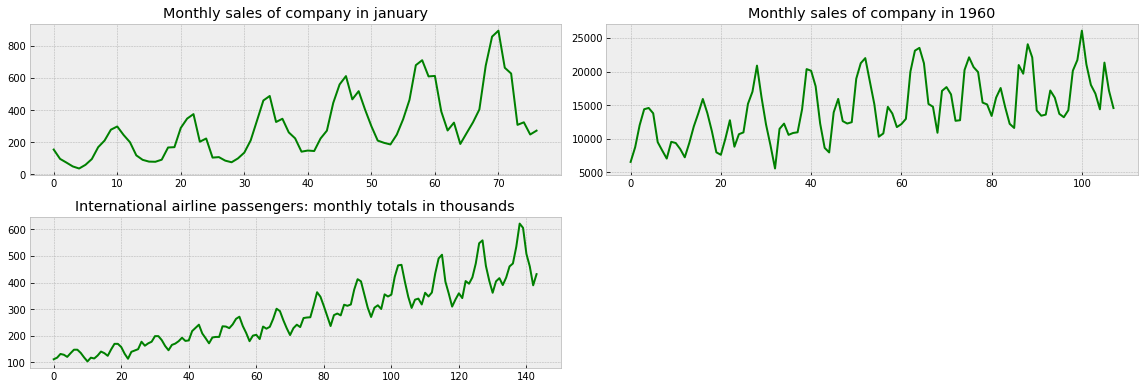

In [13]:
# Если Мы хотим использовать стиль только для определенного блока кода, но не хотим изменять 
# глобальный стиль, пакет стилей предоставляет диспетчер контекста 
# для ограничения наших изменений определенной областью
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)                              # компоновка
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))  # гибкий способ расположения графиков с помощью фунции subplot2grid, 
                                                  # которая позволяет занимать графику несколько ячеек таблицы
        all_series[key].plot(ax=ts_ax, color='green')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [47]:
def plot_ts_and_points(ts, start_point, step):
    """
    Функция для поиска сезонности во временных рядах
    """
    new_series = [None for i in range(len(ts))]  
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='green')
        new_series.plot(ax=ts_ax, style='ro')

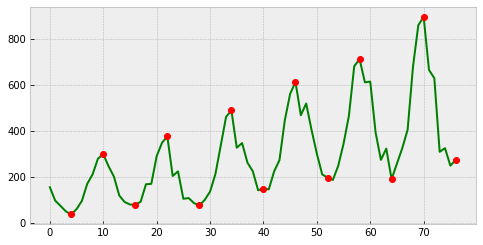

In [48]:
# видим, что каждые полгода (6 месяцев наблюдаются экстремумы в точках)
plot_ts_and_points(sales_of_company_jan['Count'], 4, 6)

In [49]:
# Теперь попробуем понять, является ли ряд стационарным. Если он таковым является, значит, по нему легко предсказывать 
# будущие состояния, ведь стат.характеристики неизменны (дисперсия, среднее, ковариация не зависит от времени,
#                                                       а от расстояния между наблюдениями)
# с первого взгляда понятно, что матожидание и дисперсия возрастают; нормализуем дисперсию

# Метод boxcox возвращает набор данных, преобразованный степенным преобразованием Бокса-Кокса:
# подается: 
#     - входной массив, 
#     - lmbda{None, scalar} - необязательный (опциональный) параметр; 
# Если lmbda не равно None, выполним преобразование для этого значения
series = boxcox(all_series['International airline passengers: monthly totals in thousands'], 0)

C:\Users\zlatt\anaconda3\lib\site-packages\scipy\stats\morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


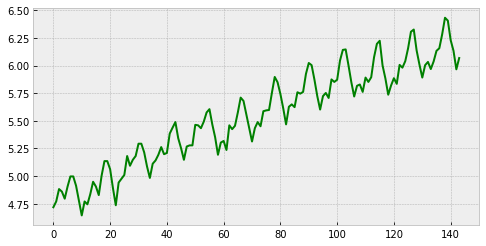

In [50]:
with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color='green')

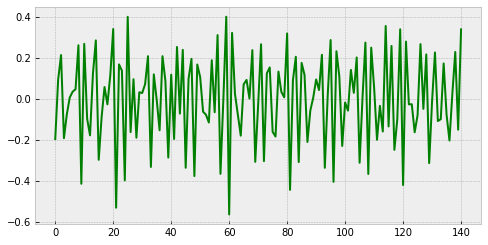

In [55]:
# Продолжим делать ряд стационарным. Нормализовав дисперсию (сделав ее постоянной), произведем дифференцирование ряда
series = np.diff(series, 2)
with plt.style.context('bmh'):
        plt.figure(figsize=(8, 4))
        plt.plot(series, color='green')
# Теперь мы визуально видим: ряд имеет постоянное матожидание, примерно одинаковую дисперсию и одинаковую плотность

In [61]:
# Так ли нормализован ряд, как мы предполагаем? проведем тест Дики-Фуллера
def test_stationarity(timeseries):
    """
    Тест Дики-Фуллера может использоваться для проверки единичного корня 
    в одномерном процессе при наличии последовательной корреляции
    """
    print('Результат теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC') # передаем массив данных для тестирования
                                                 # maxlag: Максимальная задержка, включенная в тест, 
                                                      # по умолчанию 12*(nobs/100)^{1/4}
                                                 # регрессия {"c", "ct", "ctt", "nc"}
                                                      # «C»: только константа (по умолчанию).
                                                      # «Ct»: константа и тренд.
                                                      # «Ctt»: постоянный, линейный и квадратичный тренд.
                                                      # «Nc»: нет константы, нет тенденции
                                                 # autolag {«AIC», «BIC», «t-stat», None}
                                                      # Метод, используемый при автоматическом определении длины лага 
                                                      # среди значений 0, 1,…, maxlag
                                                 # store: Если True, то экземпляр результата возвращается 
                                                      # дополнительно к статистике adf
                                                    # regresults: Если True, возвращаются полные результаты регрессии
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [62]:
test_stationarity(series) # показатели для нормализованного ряда

Результат теста Дики-Фуллера:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [58]:
# показатели для ненормализованного ряда
test_stationarity(all_series['International airline passengers: monthly totals in thousands'])

Результат теста Дики-Фуллера:
Test Statistic                        NaN
p-value                               NaN
#Lags Used                       0.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [ ]:
# Тест на стационарность: если тестовая статистика меньше критического значения, 
# мы можем отвергнуть нулевую гипотезу (то есть ряд является стационарным). 
# Когда статистика теста больше критического значения, мы не можем отклонить нулевую гипотезу 
# (что означает, что ряд не является стационарным).

# В нашем примере выше тестовая статистика дает показатель NaN: проверка не является корректной 
# Полагаемся на визуальный анализ нормализованого ряда, который из нестационарного стал стационарным 